## Notebook Configuration && Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [84]:
import pandas as pd

from storesales.baseline.sales_predictor import SalesPredictor
from storesales.baseline.explore_utils import (
    family_store_con,
    store_family_prediction_plot,
)
from storesales.baseline.utils import (
    run_study,
    load_baseline_data,
    make_time_series_dataset,
    evaluate,
)
from storesales.baseline.model_wrappers import (
    DailyMeanModelWrapper,
    WeightedDayMeanModelWrapper,
)
from storesales.baseline.param_suggestions import (
    IntSuggestions,
    FloatSuggestions,
)
from storesales.baseline.constants import STORES
from storesales.constants import (
    TRAIN_TEST_SPLIT_DATE,
    HORIZON_STR,
    LOSSES_DATA_PATH,
    MODELS_PATH,
)

## Load Data && Create Dataset

In [3]:
train_df, test_df, holidays_df = load_baseline_data(use_light_gbm_preprocessing=False)

In [4]:
train_test_split_date = pd.Timestamp(TRAIN_TEST_SPLIT_DATE)

outer_cutoffs_dates = [
    "2016-08-16",
    "2016-11-18",
    "2017-02-20",
    "2017-04-04",
]
outer_cutoffs = [pd.Timestamp(date) for date in outer_cutoffs_dates]

for cutoff in outer_cutoffs:
    if cutoff + pd.Timedelta(HORIZON_STR) >= train_test_split_date:
        raise ValueError(f"cutoff {cutoff} falls into test period!")

In [6]:
# families = ["FROZEN FOODS", "EGGS"]
families = ["BREAD/BAKERY", "CELEBRATION", "LADIESWEAR"]
# families = train_df["family"].unique()

family_groups = [(family,) for family in families]

family_group_to_stores = dict(
    [[family_group, STORES] for family_group in family_groups]
)

In [65]:
families_data = train_df[train_df["family"].isin(families)]
families_test_data = test_df[test_df["family"].isin(families)]

In [8]:
train_dataset = make_time_series_dataset(families_data, outer_cutoffs, 16)

100%|██████████| 162/162 [00:00<00:00, 237.36it/s]


## SalesPredictor
### DailyMeanModel

In [9]:
daily_wrapper = DailyMeanModelWrapper(int_suggestions=[IntSuggestions("window", 3, 60)])

daily_wrapper_dict = {DailyMeanModelWrapper.__name__: daily_wrapper}

daily_optuna_kwargs = dict(
    n_trials=100,
    show_progress_bar=False,
    timeout=45,
)

daily_predictor = SalesPredictor(
    model_wrappers=daily_wrapper_dict,
    family_groups=family_groups,
    inner_cutoffs=[-365, -180, -49, -17],
    optuna_optimize_kwargs=daily_optuna_kwargs,
    n_group_store_family_choices=4,
    n_single_store_family_choices=3,
    family_group_to_stores=family_group_to_stores,
    initial=None,
)

In [10]:
daily_predictor = run_study(train_dataset, daily_predictor, disable_tqdm=False)

Family Group: ('BREAD/BAKERY',):


100%|██████████| 3/3 [00:12<00:00,  4.26s/it]


RMSLE: 0.29786936113020174
Family Group: ('CELEBRATION',):


100%|██████████| 3/3 [00:12<00:00,  4.16s/it]


RMSLE: 0.5888737929169227
Family Group: ('LADIESWEAR',):


100%|██████████| 3/3 [00:12<00:00,  4.33s/it]

RMSLE: 0.4540951538401174


In [11]:
daily_eval_loss = evaluate(families_data, daily_predictor, disable_tqdm=False)

100%|██████████| 82/82 [00:08<00:00, 10.03it/s]


In [12]:
daily_store_loss = daily_eval_loss.mean(axis=1).rename("daily_rmsle")

In [13]:
daily_store_loss.groupby(level="family").mean()

family
BREAD/BAKERY    0.236766
CELEBRATION     0.594309
LADIESWEAR      0.501788
Name: daily_rmsle, dtype: float64

### WeightedDayMeanModelWrapper

In [15]:
weighted_day_mean_wrapper = WeightedDayMeanModelWrapper(
    int_suggestions=[
        IntSuggestions("days_window", 1, 20),
        IntSuggestions("weeks_window", 1, 10),
        IntSuggestions("months_window", 0, 12),
        IntSuggestions("years_window", 0, 4),
    ],
    float_suggestions=[
        FloatSuggestions("day_weight", 0.88, 1.12),
        FloatSuggestions("week_weight", 0.88, 1.12),
        FloatSuggestions("month_weight", 0.88, 1.12),
        FloatSuggestions("year_weight", 0.88, 1.12),
        FloatSuggestions("bias", -100.0, 100.0),
    ],
)

weighted_day_mean_wrapper_dict = {
    WeightedDayMeanModelWrapper.__name__: weighted_day_mean_wrapper
}

weighted_day_mean_optuna_kwargs = dict(
    n_trials=100,
    show_progress_bar=True,
    timeout=45,
    n_jobs=6,
)

weighted_day_mean_predictor = SalesPredictor(
    model_wrappers=weighted_day_mean_wrapper_dict,
    family_groups=family_groups,
    inner_cutoffs=[-365, -180, -49, -17],
    optuna_optimize_kwargs=weighted_day_mean_optuna_kwargs,
    n_group_store_family_choices=4,
    n_single_store_family_choices=3,
    family_group_to_stores=family_group_to_stores,
    initial=None,
)

In [ ]:
weighted_day_mean_predictor = run_study(
    train_dataset, weighted_day_mean_predictor, disable_tqdm=False
)

In [17]:
weighted_day_loss = evaluate(
    families_data, weighted_day_mean_predictor, disable_tqdm=False
)

100%|██████████| 82/82 [01:19<00:00,  1.03it/s]


In [18]:
weighted_day_store_loss = weighted_day_loss.mean(axis=1).rename("weighted_day_rmsle")

### Explore Losses

In [19]:
losses = pd.concat([daily_store_loss, weighted_day_store_loss], axis=1)

In [20]:
losses.groupby(level="family").mean()

,daily_rmsle,weighted_day_rmsle
family,,
BREAD/BAKERY,0.236766,0.195186
CELEBRATION,0.594309,0.579963
LADIESWEAR,0.501788,0.527698


In [22]:
losses["diff"] = losses["daily_rmsle"] - losses["weighted_day_rmsle"]

In [23]:
losses

daily_rmsle  weighted_day_rmsle      diff
family       store_nbr                                           
BREAD/BAKERY 1             0.335452            0.272606  0.062846
             2             0.183433            0.140871  0.042562
             3             0.167034            0.142611  0.024422
             4             0.221481            0.178975  0.042506
             5             0.164552            0.137270  0.027282
...                             ...                 ...       ...
LADIESWEAR   50            0.693770            0.640489  0.053281
             51            0.893638            0.877674  0.015963
             52            0.711818            0.634125  0.077693
             53            0.811009            0.736281  0.074728
             54            0.000000            0.175997 -0.175997

[162 rows x 3 columns]

In [93]:
family_to_plot = "BREAD/BAKERY"
store_nbr_to_plot = 20

data_to_plot_df = family_store_con(train_df, family_to_plot, store_nbr_to_plot)
test_data_to_plot_df = family_store_con(test_df, family_to_plot, store_nbr_to_plot)

100%|██████████| 1/1 [00:00<00:00, 29.41it/s]


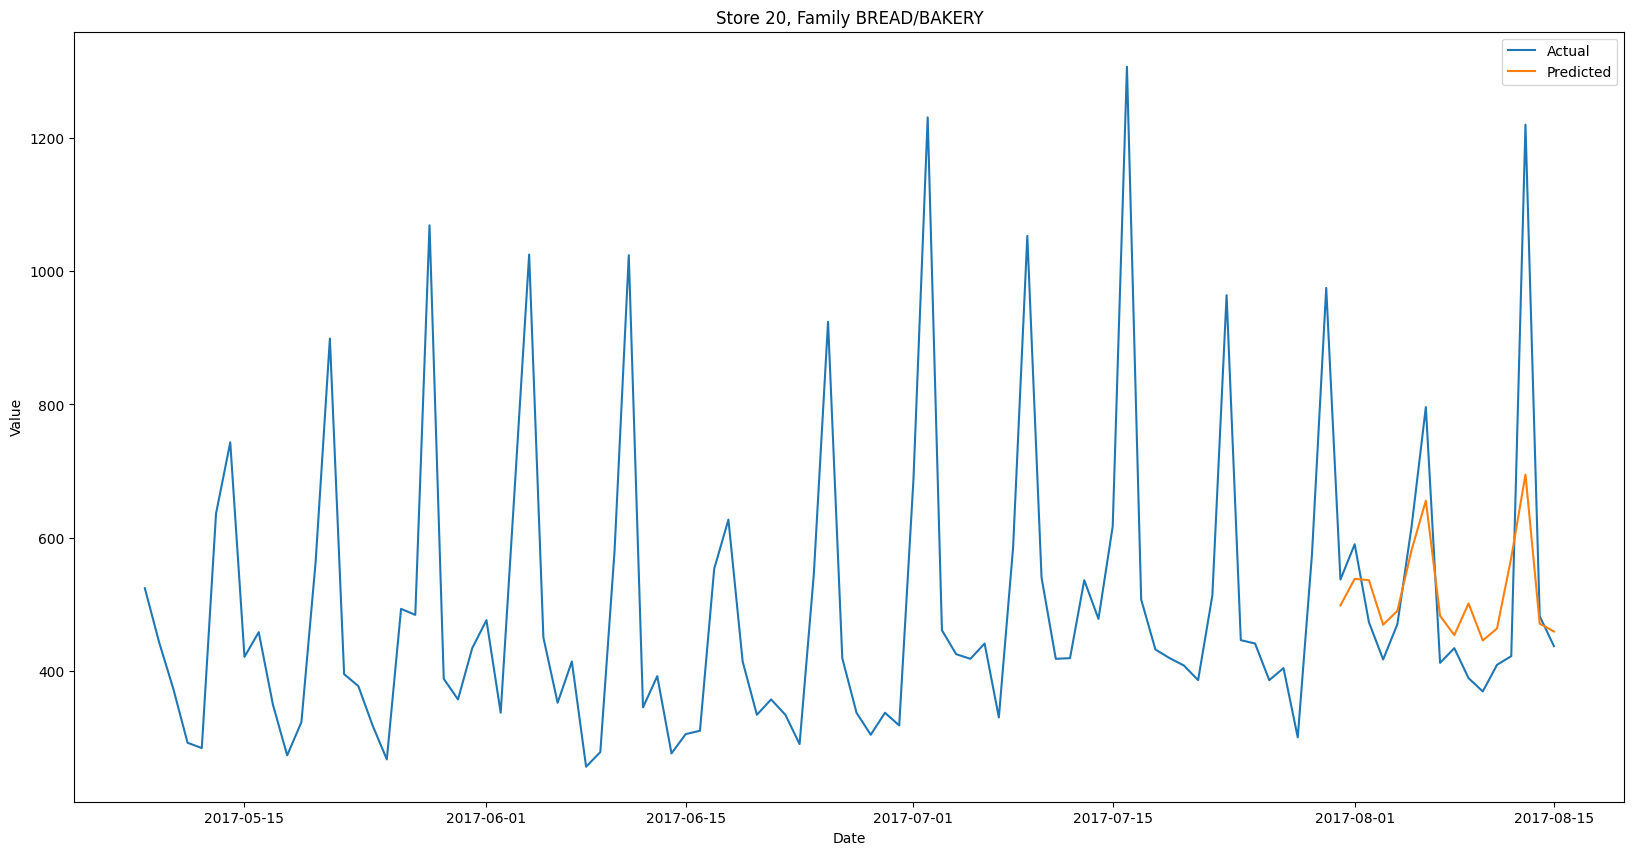

In [94]:
store_family_prediction_plot(
    predictor=weighted_day_mean_predictor, 
    data_to_plot=data_to_plot_df, 
    family=family_to_plot, 
    store_nbr=store_nbr_to_plot, 
    # test_data=test_data_to_plot_df,
    data_slice=100
)

### Explore WeightedDayMeanModel Params

In [37]:
weighted_day_mean_predictor.family_to_model_params_storage

{'BREAD/BAKERY': {'params': {'model': 'WeightedDayMeanModelWrapper',
   'days_window': 12,
   'weeks_window': 7,
   'months_window': 6,
   'years_window': 0,
   'day_weight': 0.9778297882078566,
   'week_weight': 1.0419397942142952,
   'month_weight': 1.0152592502284237,
   'year_weight': 0.9405397477230735,
   'bias': 0.7689667808917399},
  'stores': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
         35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
         52, 53, 54]),
  'loss': 0.30216090408663693},
 'CELEBRATION': {'params': {'model': 'WeightedDayMeanModelWrapper',
   'days_window': 10,
   'weeks_window': 5,
   'months_window': 4,
   'years_window': 1,
   'day_weight': 1.0103500530523115,
   'week_weight': 0.9902678814535965,
   'month_weight': 0.9908999148182502,
   'year_weight': 0.96717630598237,
   'bias': 0.029285331491701986},
  'stores': array([ 1

### Save Model

In [ ]:
import os

In [ ]:
predictor_to_save = daily_predictor
loss_df_to_save = daily_eval_loss

In [ ]:
predictor_to_save.fit(families_data)

In [ ]:
loss_file = os.path.join(LOSSES_DATA_PATH, "test_daily_eval_loss.csv")
loss_df_to_save.to_csv(loss_file, index=True)
predictor_to_save.eval_loss_csv = loss_file

In [ ]:
model_file = os.path.join(MODELS_PATH, "test_daily_predictor.pkl")
predictor_to_save.save(model_file)